# Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what do each scenario corresponds to?

**Answer** : 
* the first scenario corresponds to two visually seperate gaussian variables.
* the second scenario corresponds to 2 visually non seperate gaussian variables. we can see that they are overlapping on the first diagonal .
* the third scenario corresponds to two visually non separable variables.
we can see that the class 0 and class 1 elements are overlapping on each other especially in the center
* the last scenario corresponds to circles.

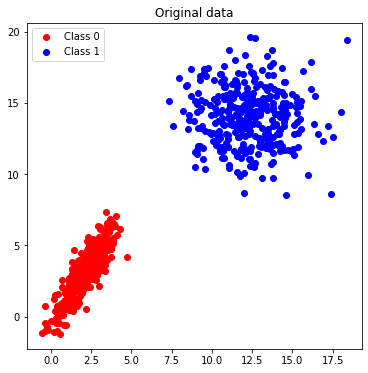

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA. 


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

#Scenario 1 :

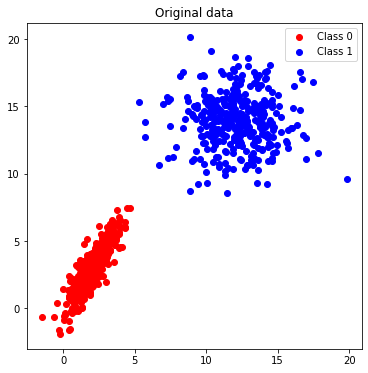

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()


The variance explained by the two first modes is respectively:  [0.96114618 0.03885382]


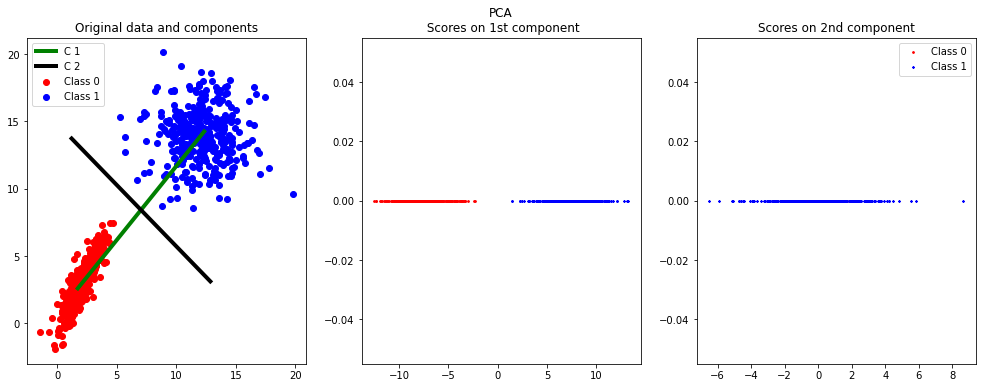

In [ ]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

We can see that, the PCA works perfectly for this scenario.In fact, we can clearly retreive the information when we project the data on the first component of the PCA.<br>
The representation with the second component is not really helpfull.
<br> We can also see that the variance of the first component is equal to 0.96. it means that it explains 96% of the total variability which is quite satisfying 

#Scenario 2 :

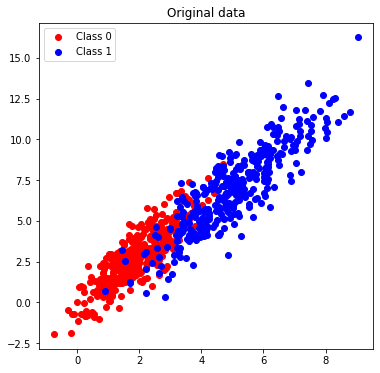

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()


The variance explained by the two first modes is respectively:  [0.97140345 0.02859655]


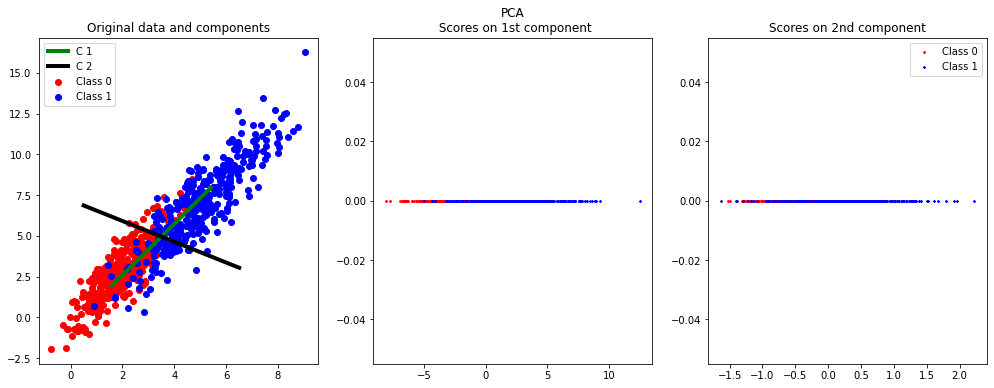

In [ ]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

We can see that on both projections on 1st and 2nd PCA components, we cannot seperate between the elements of both classes. The PCA does not work well with overlapping sources.
It is also to mention that on the first component projection, we still have a little ability to seperate between the data while also missclassifying some points.

#Scenario 3 :

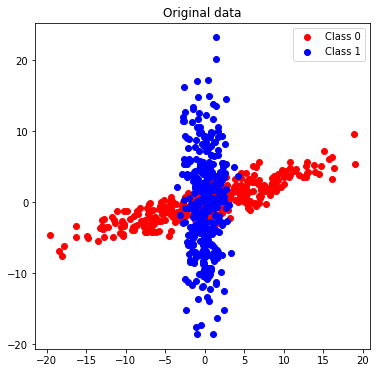

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.65140684 0.34859316]


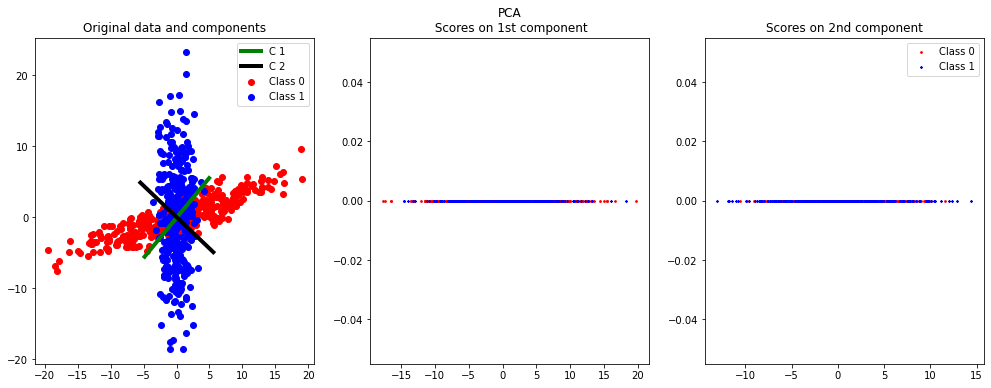

In [ ]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

We can see that on both projections on 1st and 2nd PCA components, we cannot seperate between the elements of both classes. The PCA does not work with overlapping sources.

#Scenario 4

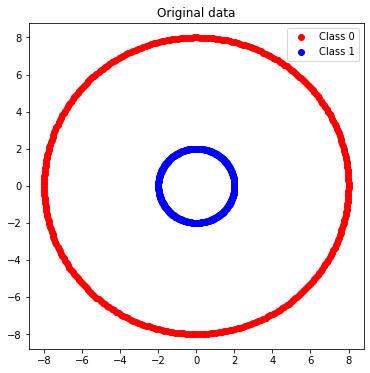

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


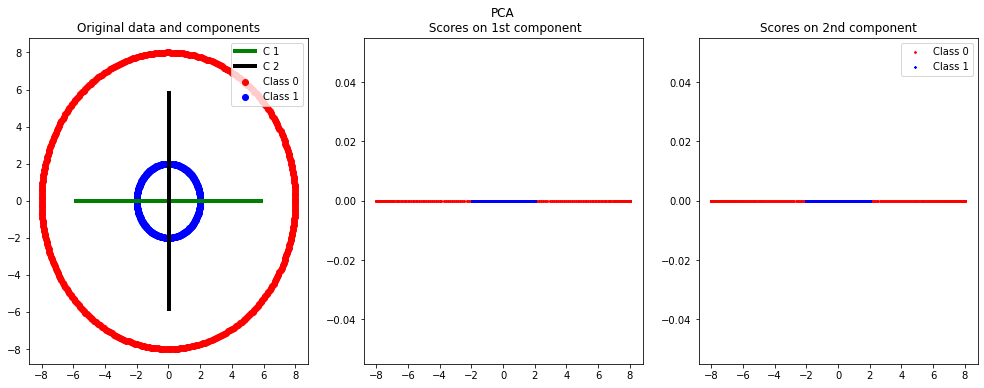

In [ ]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

On this scenario we have two concentric sources, we can see that the data is not linearly separable. It is then not possible to seperate between both classes with the projection on the first and the second component.That's why we obtain such graphs.<br>
An optimal approach is to consider using the Kernel PCA in order to differenciate between both classes.

$=>$ In summary, PCA is an orthogonal transformation of the data into a series of uncorrelated data living in a reduced PCA space such that the first component explains the most variance in the data with each subsequent component explaining less . The PCA technique is particularly useful in processing data where multi-colinearity exists between the features/variables (as we can see in the first scenario where the sources are well separated).

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [3]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    Xc=X-np.mean(X) # centering
    _,D2, Uh = LA.svd(Xc) # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    Y=Xc.dot(U) # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    tot=np.sum(D)
    D=list(D)
    var_explained =D/tot  # computation of explained variance
    return Y,U,D,var_explained

**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

Scenario 1

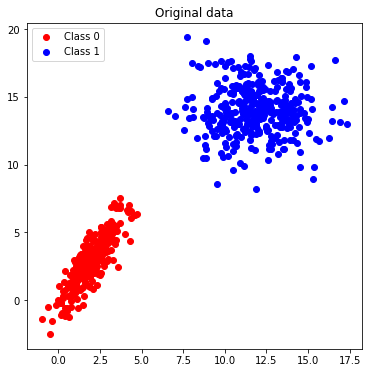

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.94721473 0.05278527]


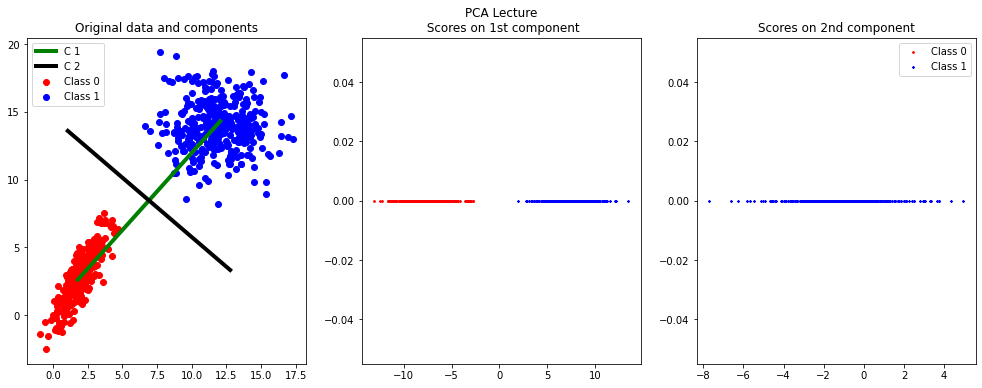

In [ ]:
X=np.concatenate((X0,X1),axis=0)
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

* Graphically,there is no differences between the lecture code and the sickit learn algorithm.In terms of the variance explained by each variable, there is a little difference.

Scenario 2

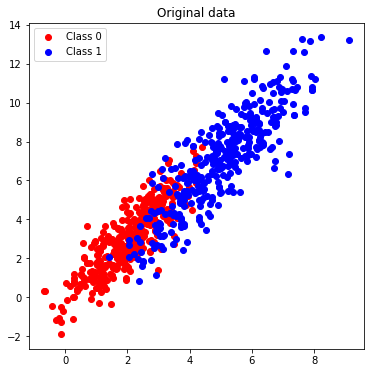

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.88873856 0.11126144]


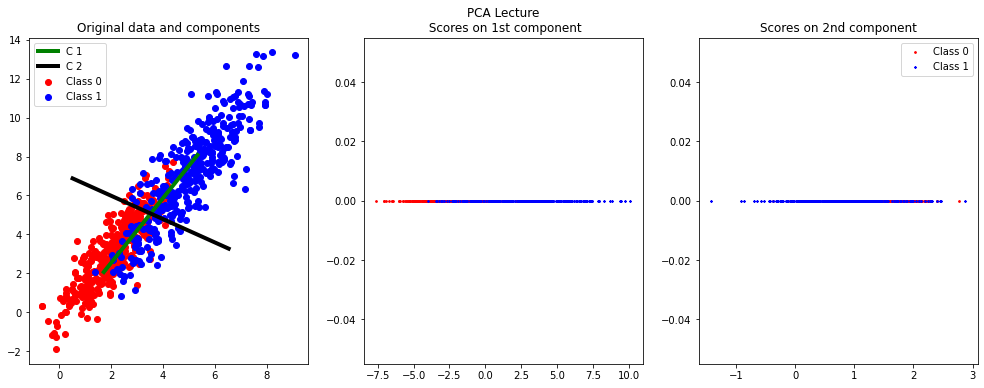

In [ ]:
X=np.concatenate((X0,X1),axis=0)
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

* Graphically,there is no differences between the lecture code and the sickit learn algorithm.In terms of the variance explained by each variable, there is a little difference.

Scenario 3

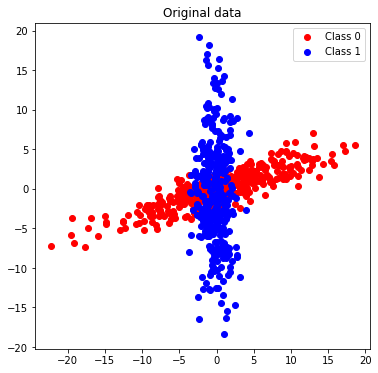

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.64296903 0.35703097]


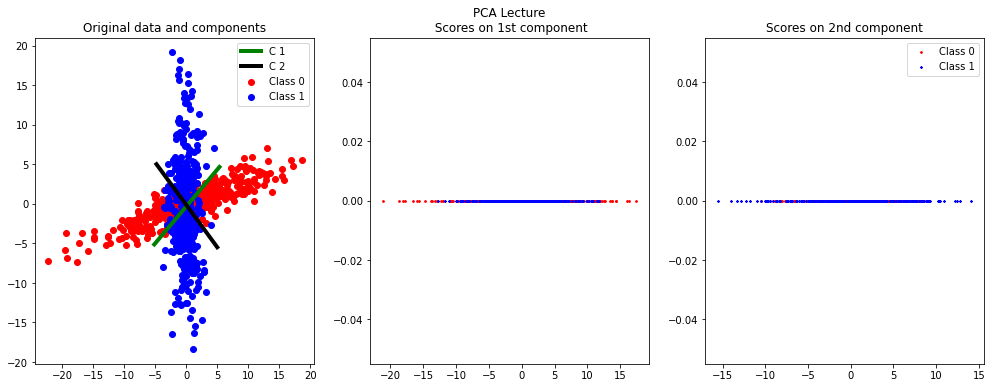

In [ ]:
X=np.concatenate((X0,X1),axis=0)
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

* We can see for this case, that there is a little difference with the sickit learn algorithm.

Scenario 4

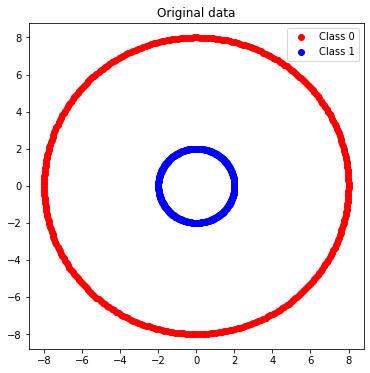

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


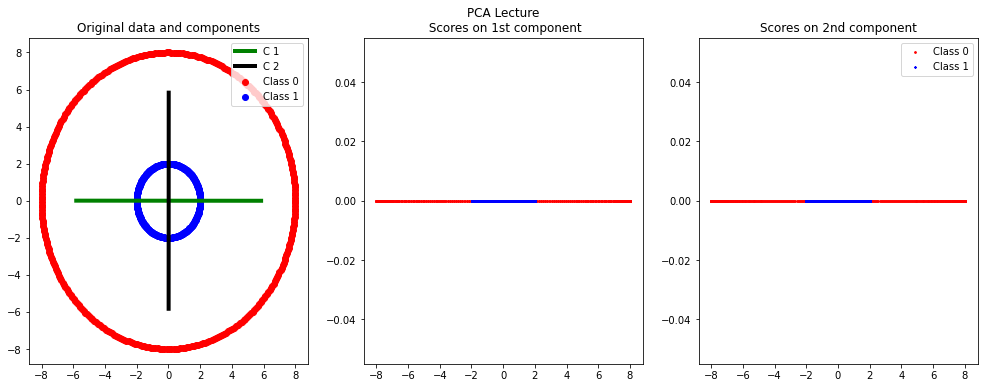

In [ ]:
X=np.concatenate((X0,X1),axis=0)
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

* Exactly the same as the result with the sickit learn algorithm.

**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?
2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

**Answer 1:**
The interest of Kernel PCA over the basic PCA is that it maps the data points into a higher dimensional space where sources of the data could be well identified.
It helps us also avoiding the linearity constraint.

#Scenario 1

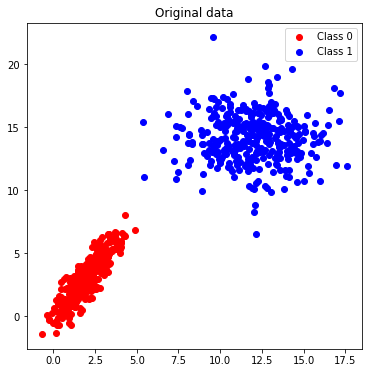

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


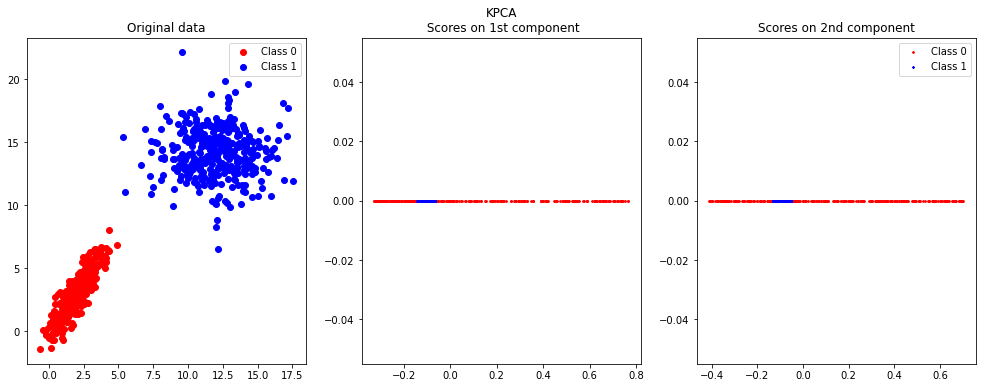

In [ ]:
# Kernel-PCA
gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

* We can see that the 'rbf' kernel is not giving satisfying results to seperate between the two classes. By looking into the documentation of the function, i found that we could use the 'linear' kernel (since here in our case, it is linear). This gave me better results as you can see in the following cell 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


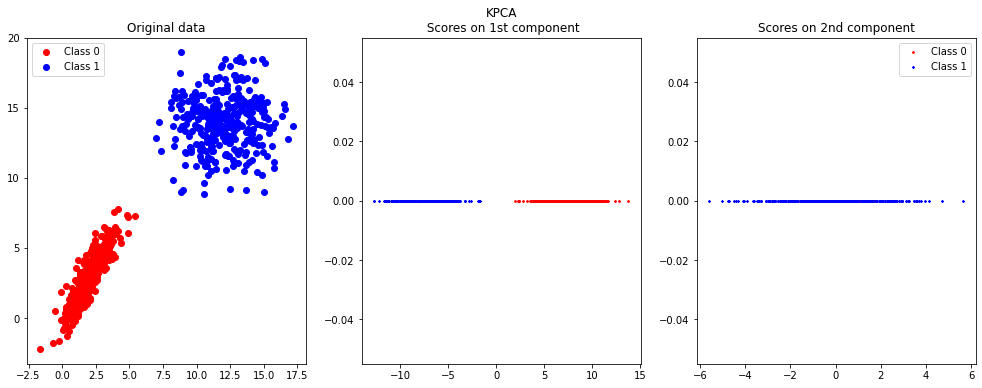

In [ ]:
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma=2
Kpca = KernelPCA(kernel='linear', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_
plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

#Scenario 2

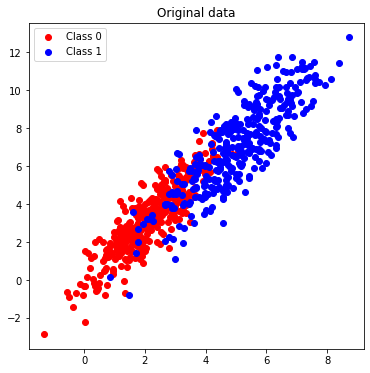

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


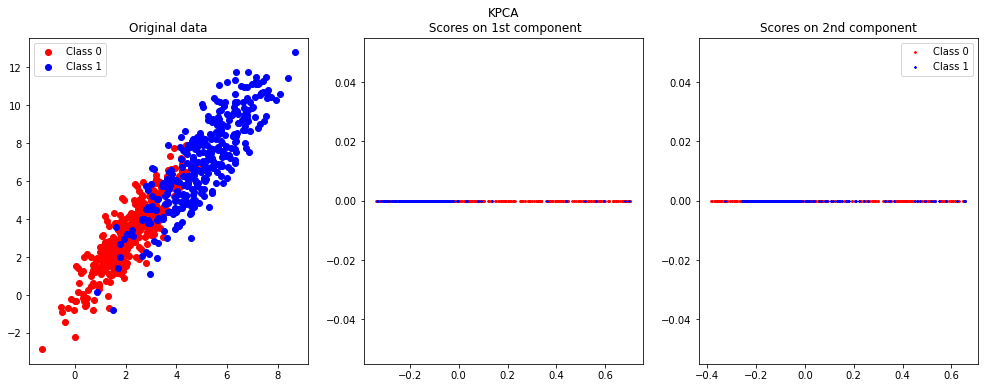

In [ ]:
# Kernel-PCA
gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

* We can see that the 'rbf' kernel is not giving satisfying results to seperate between the two classes. I tried with 'linear' kernel . This gave me the following results:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


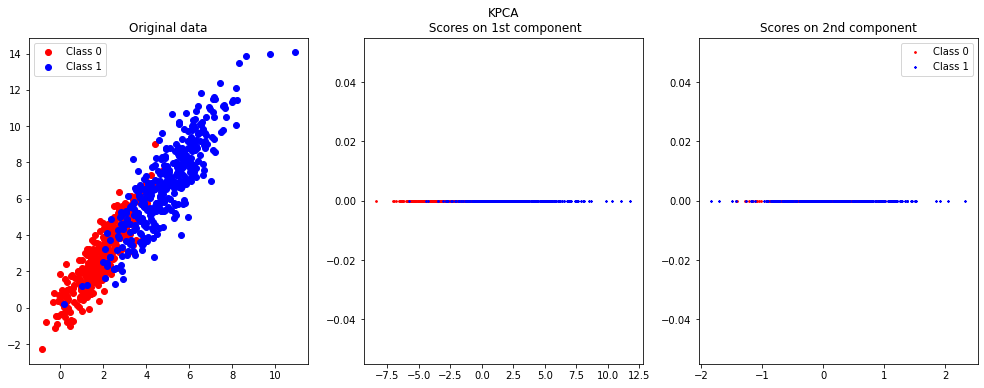

In [ ]:
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)
gamma=2
Kpca = KernelPCA(kernel='linear', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_
plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

#Scenario 3

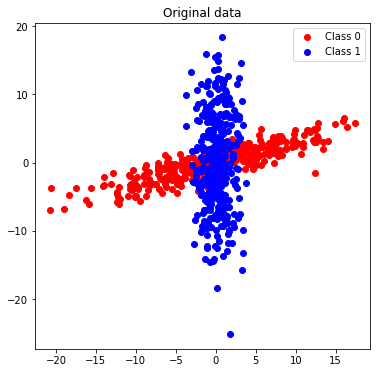

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


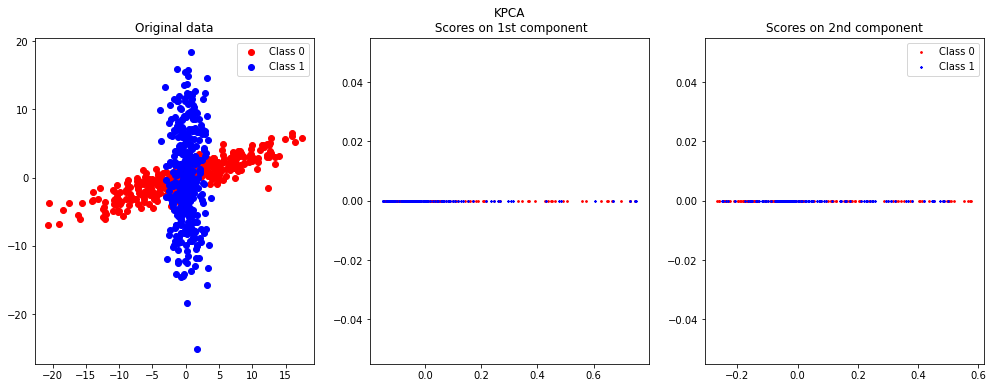

In [ ]:
# Kernel-PCA
gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

#Scenario 4

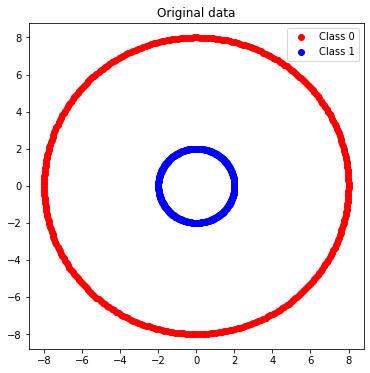

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `alphas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvectors_` instead.
  warnings.warn(msg, category=FutureWarning)


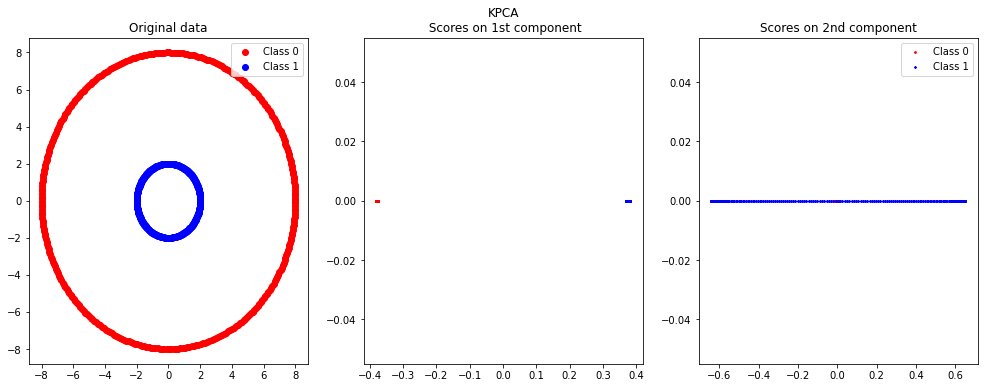

In [ ]:
# Kernel-PCA
gamma=0.125
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

* The kernel PCA (using the rbf), works well in this case since the data follows a recognisable pattern (here, both classes are circles).<br>
I changed the value of $\gamma $ to $ \frac{1}{8} $  to make sure we can distinguish between class 0 and class 1

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [4]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel 
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0) 
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;    
      K=np.exp(-Norm/(2*gamma**2))
      return K
       
    N=X.shape[0]
    K=kernel_matrix(X,gamma)
    
    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc=K-np.dot(oneN,K)-np.dot(K,oneN)+np.dot(oneN,np.dot(K,oneN)) # center kernel matrix

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance
    #print(var_explained)

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )          
           
    Y=np.dot(Kc,An) # computation of the scores  
    
    return Y,An,D,var_explained
gamma=2

Test your own implementation

Since the KPCA worked well with scenario 4,i decided to test with it the lecture algorithm.

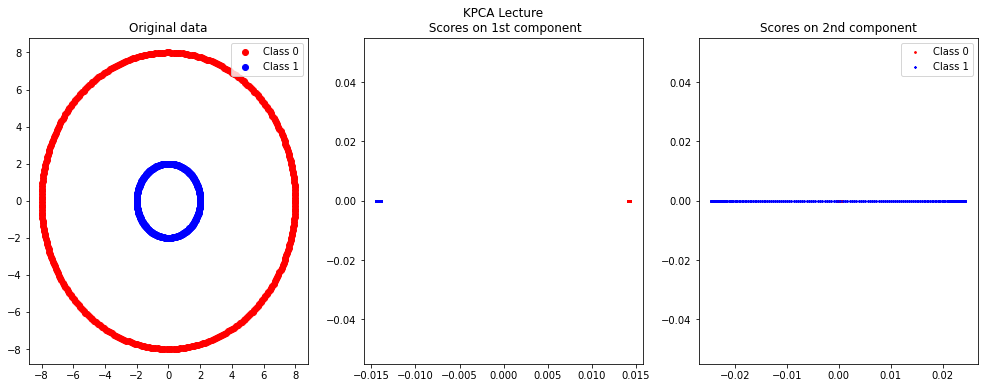

In [ ]:
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma)
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')

## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

#Scenario 1 :

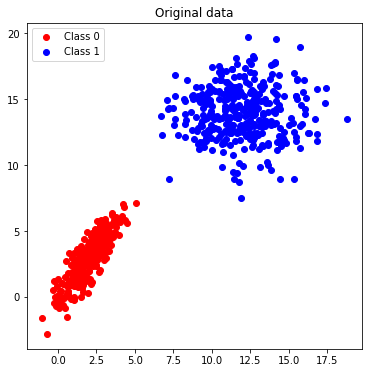

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

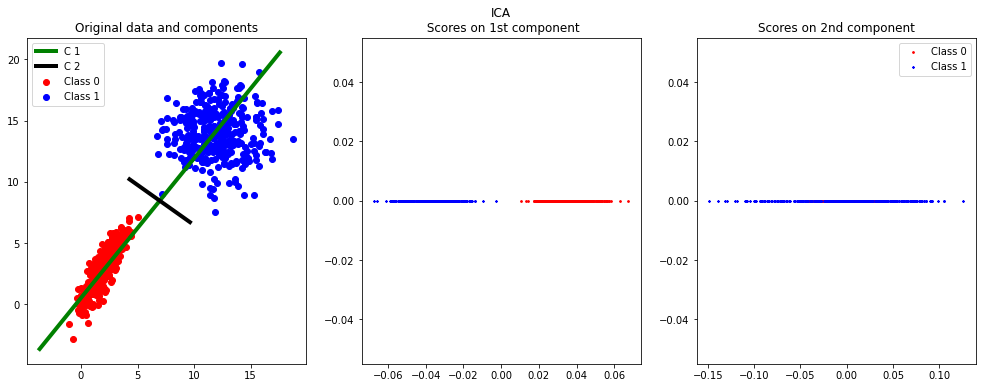

In [ ]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7f8c140687d0>])

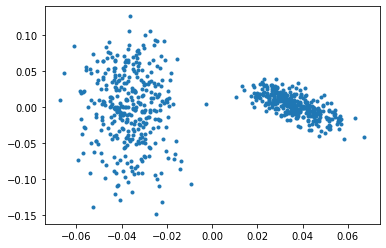

In [ ]:
plt.figure(),plt.plot(Yica[:,0],Yica[:,1],'.')

**Answer :**
For the first scenario, The ICA algorithm gives satisfying results .

#Scenario 2

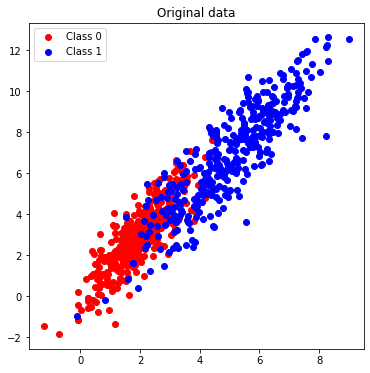

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

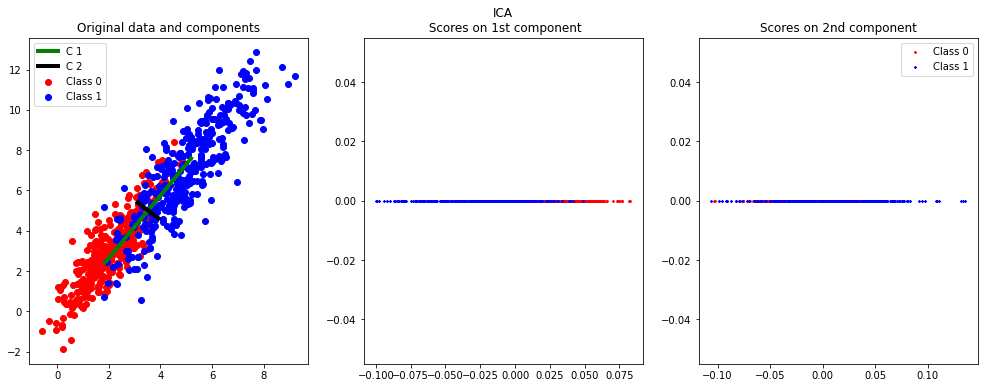

In [ ]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7ff4234b0350>])

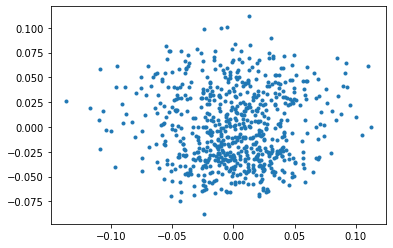

In [ ]:
plt.figure(),plt.plot(Yica[:,0],Yica[:,1],'.')

**Answer:**<br>
Eventhough in terms of results we still don't have satisfying ones, we can see that the ICA performs better than the PCA in terms of the components on wich we will project. In fact, as seen on the course the ICA performs better than the PCA on overlapping data.

#Scenario 3:

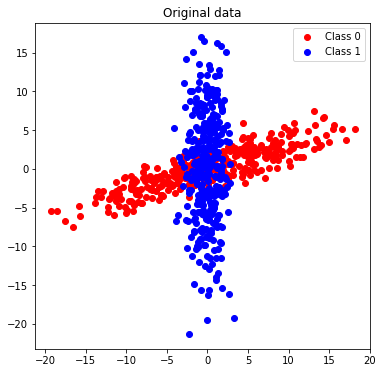

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

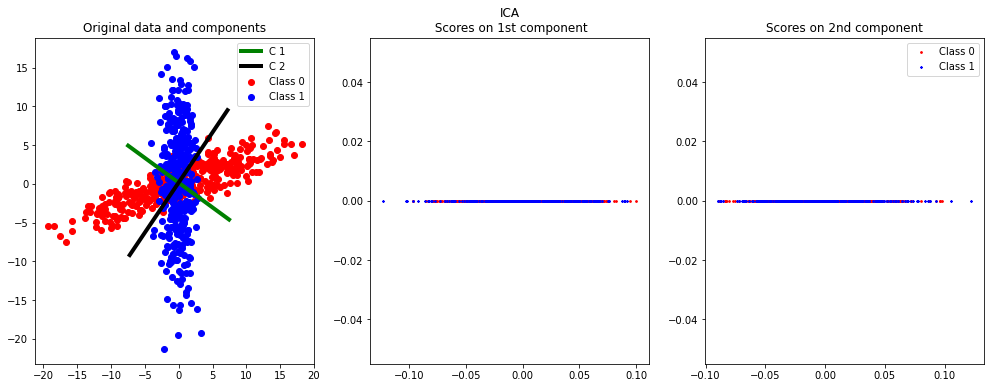

In [ ]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7ff426242110>])

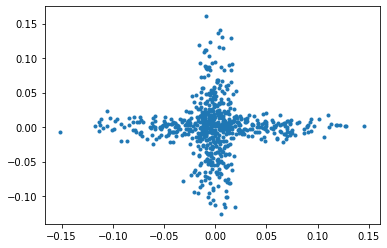

In [ ]:
plt.figure(),plt.plot(Yica[:,0],Yica[:,1],'.')

**Answer:**<br>
Eventhough in terms of results we still don't have satisfying ones, we can see that the ICA performs better than the PCA in terms of the components on wich we will project. In fact, as seen on the course the ICA performs better than the PCA on overlapping data.

#Scenario 4 :

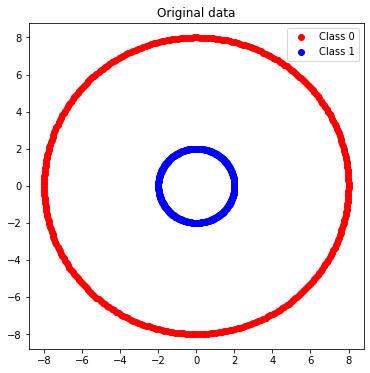

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

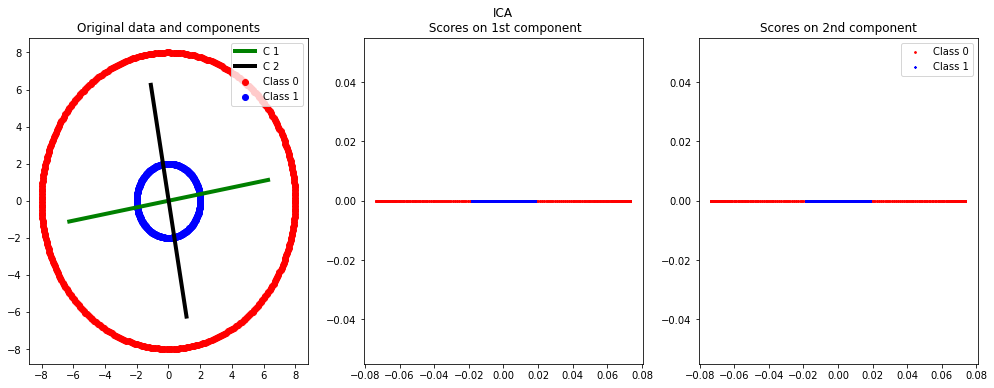

In [ ]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7ff4263b6510>])

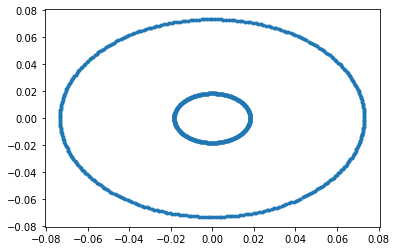

In [ ]:
plt.figure(),plt.plot(Yica[:,0],Yica[:,1],'.')

**Answer:**<br>
For the fourth Scenario, the ICA didn't give satisfying results.In fact, in this example we lost the linearity assumption.

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [5]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    
    # We choose G=-exp(-1/2t^2)
    # First derivative of G   
    def g(t):
        res = t*np.exp(-(1/2)*(t**2))
        return res
    
    # Second derivative of G  
    def gp(t):
        res = np.exp(-(1/2)*(t**2)) - t**2 * np.exp(-(1/2)*(t**2))
        return res
    
    # Size of X
    d,N=X.shape 
        
    # Compute sample mean
    mu = np.mean(X,keepdims=True)
    
    # Center data
    Xc=X-mu
    
    # Compute covariance matrix
    C=np.cov(X)
    
    # Whiten data
    Sigma_demi = LA.fractional_matrix_power(C, -(1/2))
    Xcw =Sigma_demi.dot(Xc)
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        
        Wp = np.dot( g(np.dot(W, Xcw)), Xcw.T )  - np.dot( np.diag(np.sum(gp(np.dot(W, Xcw)), axis=1)),W)
        W = LA.fractional_matrix_power( np.dot(Wp, Wp.T ), -0.5).dot( Wp)
      
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')

   
    # Independent components
    S = W.dot(Xcw)
    

            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W,Xcw

Test your own implementation

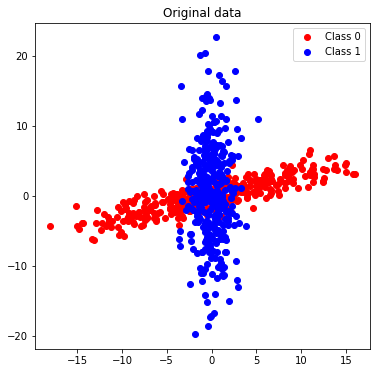

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Iteration ICA number  1  out of  3000 , delta =  0.02022753175285108
Iteration ICA number  100  out of  3000 , delta =  9.446764530851581e-06
Convergence achieved ( delta =  9.446764530851581e-06 ) in  100  iterations


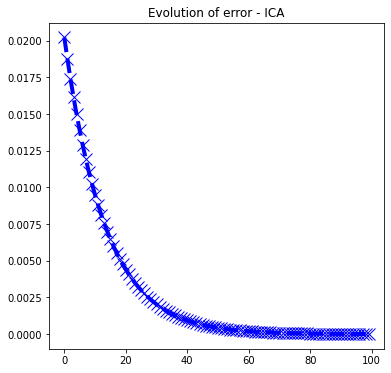

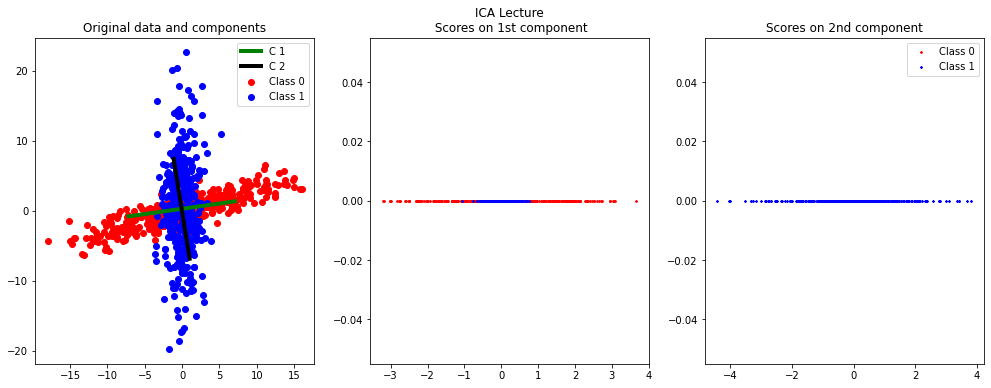

In [ ]:
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')

# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"   

Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [6]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
  

Let's load the data and compute some parameters.

In [7]:
x = loadmat( './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

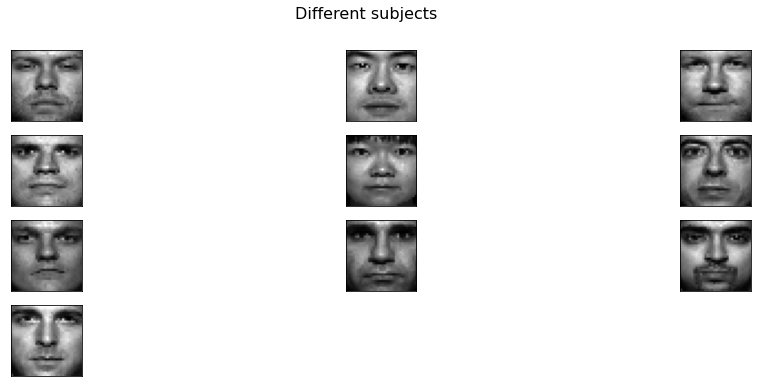

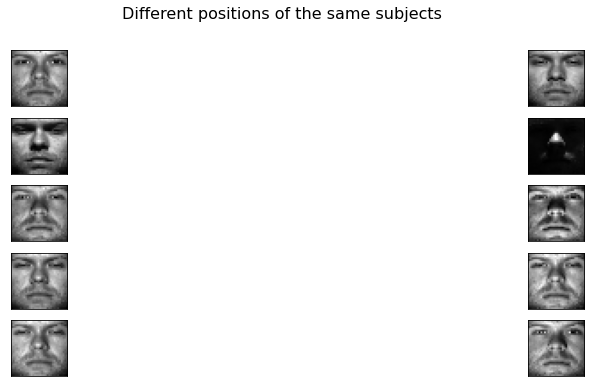

In [8]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       

We can now move to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lecture why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [10]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [11]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.7412008281573499


# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ? 
2. Look at the three main modes and explain which are the main variations in the data.

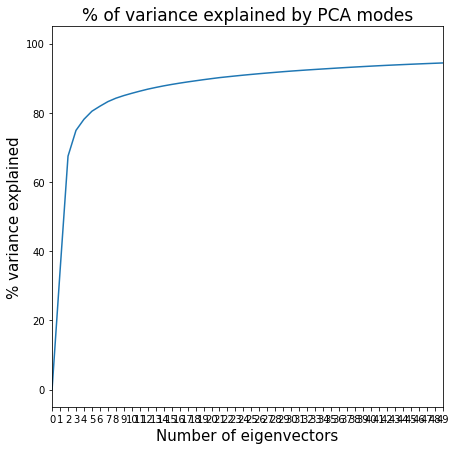

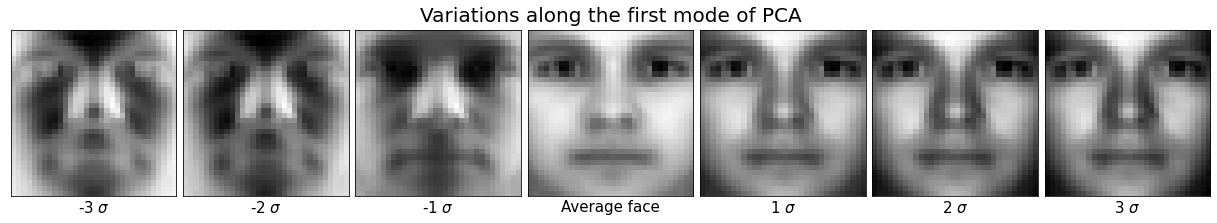

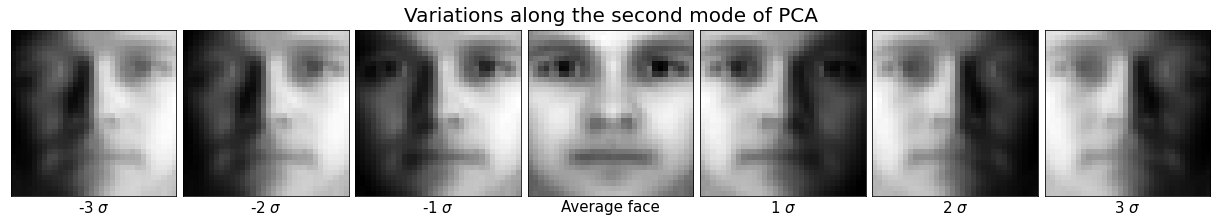

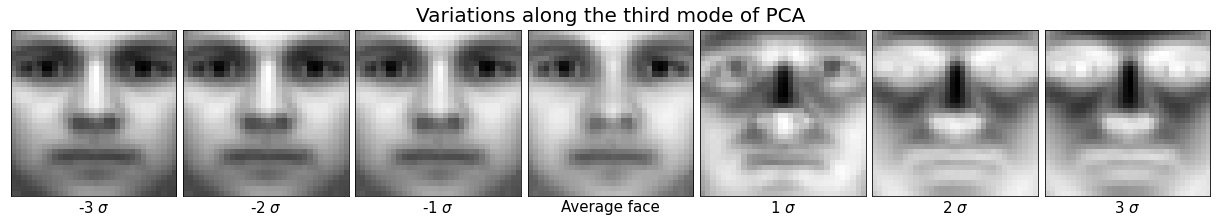

In [18]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,50,1)
plt.plot(np.concatenate(([0], np.cumsum(var_explained_pca)*100)))
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('% of variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[0]) * UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[1]) * UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[2]) * UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

**Answer**:


**Q1**

In [ ]:
V = list (var_explained_pca)
s = 0
i = 0
while s < 0.8 :  
  s+= V[i]
  i = i+1
print(" we need ",i ," modes to explain at least 80% of the variablity")

 we need  5  modes to explain at least 80% of the variablity


**Q2**

* First mode : It explains the characteristics of the individual landmarks (distance between eyes, nose size, mouth form ...).It is the most important mode.
* Second mode : It is relatied specially to the contrast of the image. In fact, for negative standard deviation, we have a dark right side of the face and for positive standard deviation,we have a dark left side of the face.
* Third mode : It explains the depth of the faces.For negative standard deviation, we see that individuals are close to the camera and for positive standard deviation, we see that individuals are far from the camera.

**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:** 

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Theoretical Questions:** 

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

[3.61515997e-01 3.51107644e-01 4.81076420e-02 ... 2.40515725e-07
 2.35403406e-07 2.30060619e-07]
PCA uses  233  features
(483, 1)
(483, 233)
Percentage of correct answer using PCA is  0.7122153209109731


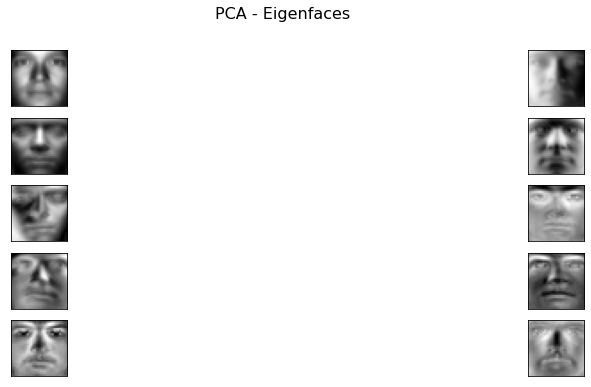

In [ ]:
## PCA (scikit-learn implementation)
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
YpcaTrain=pca.fit_transform(Xctrain)
UpcaTrain=pca.components_.T # we want PC on columns
DpcaTrain = (pca.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues
print(pca.explained_variance_ratio_)

# Threshold defined as 99% of the variability
Var_exp= list(pca.explained_variance_ratio_)
PCAComp=0
s=0
while s <= 0.99: 
  s += Var_exp[PCAComp]
  PCAComp = PCAComp+1
print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors 
L99Train = UpcaTrain [ : , : PCAComp] 

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Y99Train = Xctrain.dot(L99Train)
Y99Test = Xctest.dot(L99Train)
# Plot the Eigenfaces
plotFaces(L99Train.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score: apply the nearest-neighboor algorithm to PCA output
NN.fit(Y99Train,Id_Train.ravel())
print(Id_Test.shape)
print(Y99Test.shape)
print('Percentage of correct answer using PCA is ', NN.score(Y99Test,Id_Test))



**Answer(Practical Question):** <br>
1.After using PCA while connserving 99% of the variability, The accuracy decreased from 0.74 to 0.71.On the other hand, we passed from 1024 feature to only 232 which is quite interesting in terms of execution time.
Globally speaking, the eigenfaces seem real, but after focusing on each one by its own, we can see some non normal deformations (of the mouth , of the nose ..).


**Answers(Theoretical Questions)**<br>
1. Centering the data before using the PCA helps us considering only the variability of the data. In fact, if we don't center the data,we will be also having the variability according to the origin.Moreover, thanks to centering the data, we can compute easily the covariance matrix. Also, by performing SVD on X, we get the same results as the ones we get by the PCA on the covariance matrix.
2. By taking all the eigenvalues, no dimension reduction was done but we took another base to work on. We can say that X and Y are not equal but they represent the same information. Moreover,  $ Y = X U $ so $Y$ is equal to $X $ only if U is the identity.<br>
The advantage presented by Y is that it is an orthogonal basis.<br>
In practice, the execution time is really an important parameter.For this reason, we select only the eigenvectors that illustrate the majority of the data variability(reduces execution time ).
3. We got $ y_p y_q = x_p (U U^T)x_q^T = x_p x_q^T $because U is orthogonal matrix so $(U U^T)=1$
<br>
4. We have $ Y = X U $ so :  <br> $ Cov(Y) = Cov(XU) = U^T Cov(X) U = U^T C U  $<br>
Since $ C = U D U^T $ we got :<br>
$U^T C U = (U^TU) D (U^TU) = D $<br><br>
Used tools:<br>
$(U U^T)=1$ because U is an orthogonal matrix. <br> 
$ cov(AU) = U^Tcov(A) U $ for every deterministic matrix U. 

**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:** 

1.  Use the scikit-learn implementation to test the performance
2. Look for the best gamma value
3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.
5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.



KPCA uses  1782  features
(483, 1931)
(1931, 1782)
(483, 1782)
Percentage of correct answer using KPCA is  0.7246376811594203


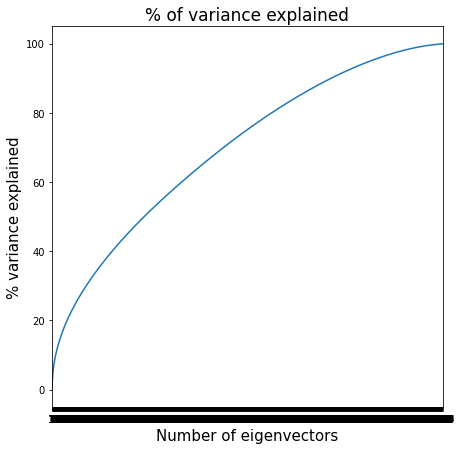

In [15]:
# Kernel-PCA (scikit-learn implementation)
## choose a gamma value
gamma=2
#
# Apply K-PCA
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(Xctrain,gamma)

# variance explained
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,1900,1)
plt.plot(np.concatenate(([0], np.cumsum(var_explainedKpca)*100)))
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('% of variance explained',fontsize=17)

# Threshold defined as 99% of the variability
Var_exp= list(var_explainedKpca)
KPCAComp=0
s=0
while s < 0.99: 
  s += Var_exp[KPCAComp]
  KPCAComp = KPCAComp+1
print('KPCA uses ', KPCAComp, ' features')

# Selection of the eigenvectors 
L = AnKpcaLec [ : , : KPCAComp] 

# Construction matrix K for test
N = Xctrain.shape[0]
M = Xctest.shape[0]
InnerX = np.dot(Xctest,Xctrain.T)
tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
NormTrain2 = np.repeat(tempTrain,M,axis=0)
NormTest2 = np.repeat(tempTest,N,axis=1) 
Norm = NormTest2+NormTrain2-2*InnerX
Norm[Norm<1e-10]=0    
Ktest=np.exp(-Norm/(2*gamma**2))

# Centering kernel test matrix
oneN=np.ones((N,N))/N
oneM=np.ones((M,M))/M
KcTest=Ktest - Ktest.dot(oneN)-oneM.dot( Ktest)+(oneM.dot(Ktest)).dot(oneN) # center kernel matrix
print(KcTest.shape)
print(L.shape)   
# Computation of the test scores using the eigenvectors computed with the training data-set        
Yr_test_KPCA=KcTest.dot(L)
print(Yr_test_KPCA.shape)
#print('KPCA uses ', YKpcaLec.shape[0], ' features')


# Score
NN.fit(YKpcaLec[ : , : KPCAComp] ,Id_Train.ravel())
print('Percentage of correct answer using KPCA is ', NN.score(Yr_test_KPCA,Id_Test.ravel()))

In [ ]:
#Q2
g_opt=-1
max=0
for g in range (1,15):
  # Apply K-PCA
  YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(Xctrain,gamma)

  # Threshold defined as 99% of the variability
  Var_exp= list(var_explainedKpca)
  KPCAComp=0
  s=0
  while s < 0.99: 
    s += Var_exp[KPCAComp]
    KPCAComp = KPCAComp+1
  print('KPCA uses ', KPCAComp, ' features')

  # Selection of the eigenvectors 
  L = AnKpcaLec [ : , : KPCAComp] 

  # Construction matrix K for test
  N = Xctrain.shape[0]
  M = Xctest.shape[0]
  InnerX = np.dot(Xctest,Xctrain.T)
  tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
  tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
  NormTrain2 = np.repeat(tempTrain,M,axis=0)
  NormTest2 = np.repeat(tempTest,N,axis=1) 
  Norm = NormTest2+NormTrain2-2*InnerX
  Norm[Norm<1e-10]=0    
  Ktest=np.exp(-Norm/(2*gamma**2))

  # Centering kernel test matrix
  oneN=np.ones((N,N))/N
  oneM=np.ones((M,M))/M
  KcTest=Ktest - Ktest.dot(oneN)-oneM.dot( Ktest)+(oneM.dot(Ktest)).dot(oneN) # center kernel matrix   
  # Computation of the test scores using the eigenvectors computed with the training data-set        
  Yr_test_KPCA=KcTest.dot(L)
  
  # Score
  NN.fit(YKpcaLec[ : , : KPCAComp] ,Id_Train.ravel())
  Score=NN.score(Yr_test_KPCA,Id_Test.ravel())
  print('Percentage of correct answer using KPCA is ', Score)
  if (Score > max ):
    max = NN.score(Yr_test_KPCA,Id_Test)
    g_opt = gamma


KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  features
Percentage of correct answer using KPCA is  0.7246376811594203
KPCA uses  1782  feat

In [ ]:
g_opt

2

**Answers**:
2. $ \gamma = 2 $ gives the best accuracy
3. In KPCA, we project data in a higher dimension space in order to have a good separability of the data. For that reason, we are interested in the kernel $ K_c(X) = \Phi(X) \Phi(X)^T $. When we compute the eigenvectors for $K_c(X) $ , we will obtain a vector $ \alpha_i $ of size N ( Number of samples) that we can not plot.
4. **Performance:**  depends on the dataset that we are working with.For our example, when we applied the PCA for the face recognition problem, the accuracy decreased from 0.74 to 0.71. It is acceptable, but we have a little lower performance than using the original pixels. In some cases, using the pca may help in term of performance because with many features the algorithm can give bad results.<br>
<br> **Computational time:** using PCA/KPCA is a huge advantage, because we pass from a big number of feature to few ones while keeping most of the variability of the data. So, if the input dimensions are too high, then applying PCA will really reduce the computaional time. <br>
<br>**Number of features:** applying PCA /KPCA, reduces the number of features. In our example,we passed from 1024 feature to just 233 while keeping 99% of the variability of the data. Which is quite interesting<br>
<br>**Interpratiblity:** By applying the PCA/KPCA, we can see that the principal components are a linear combinations of our original features.<br> For this reason, they are not as interpretable as the original features. But by applying PCA/KPCA on a high number of features, we can end up with only a small number of components that explain most of the variability of the data . It helps us visualizing the data in the new feature space. 

# II - 3) ICA

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**
 
1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?



In [13]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
YpcaTrain=pca.fit_transform(Xctrain)
UpcaTrain=pca.components_.T # we want PC on columns
DpcaTrain = (pca.singular_values_)**2/(Xctrain.shape[0]-1)

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
Var_exp= list(pca.explained_variance_ratio_)
#Var_exp= list(var_explained_pca)

PCAComp=0
s=0
while s < 0.99: 
  s += Var_exp[PCAComp]
  PCAComp = PCAComp+1
print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors 
L=UpcaTrain [ : , : PCAComp] 

# Apply ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
S=ICA.fit_transform(L.T)
W=ICA.mixing_


Y_test_ICA= np.dot( np.dot(Xctest, L), W.T)
Y_train_ICA = np.dot( np.dot(Xctrain, L), W.T)

print('ICA uses ', Y_train_ICA.shape[1], ' features')


PCA uses  233  features


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


ICA uses  1024  features


Percentage of correct answer using ICA arch.1 is  0.043478260869565216


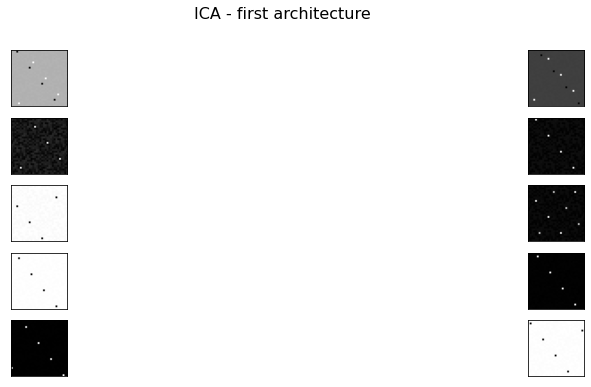

In [ ]:
# Plot the Eigenfaces
plotFaces(S,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')  

# Score
NN.fit(Y_train_ICA,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(Y_test_ICA,Id_Test.ravel()))

PCA uses  233  features
(1024, 233)
(1931, 233)
Iteration ICA number  1  out of  300 , delta =  0.9488552416998274
Iteration ICA number  100  out of  300 , delta =  0.18525420578237395
Iteration ICA number  200  out of  300 , delta =  2.076127001415795e-05
Iteration ICA number  300  out of  300 , delta =  1.3079104115631957e-05
Maximum number of iterations reached ! delta =  1.3079104115631957e-05
Percentage of correct answer using ICA is  0.7122153209109731


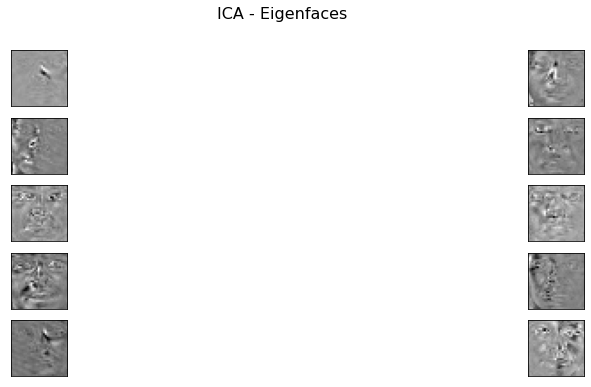

In [12]:
# Second architecture (scikit-learn implementation)
# To be done
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
YpcaTrain=pca.fit_transform(Xctrain)
UpcaTrain=pca.components_.T # we want PC on columns
DpcaTrain = (pca.singular_values_)**2/(Xctrain.shape[0]-1)
Var_exp= list(pca.explained_variance_ratio_)
PCAComp=0
s=0
while s < 0.99: 
  s += Var_exp[PCAComp]
  PCAComp = PCAComp+1
print('PCA uses ', PCAComp, ' features')
# Selection of the eigenvectors 
L = UpcaTrain [ : , : PCAComp] 
print(L.shape)
Y_train = Xctrain.dot(L)
print(Y_train.shape)
Y_test = Xctest.dot(L)

# Using lecture implementation of ICA 
S , W, Xcw = FastICALecture(Y_train.T , N_Iter=300,tol=1e-5)

Y_train_ICA2=np.dot(W,Y_train.T)
Y_test_ICA2 = np.dot(W, Y_test.T)
## Plot the Eigenfaces that are contained in the rows of S
plotFaces( (L.dot(W.T).T) ,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - Eigenfaces')       
#
NN.fit(Y_train_ICA2.T,Id_Train.ravel())
print('Percentage of correct answer using ICA is ', NN.score(Y_test_ICA2.T,Id_Test))

**Answer** 
2. The results of the second architecture are way better than the results of the firstone. In fact, the accuracy of the second is 0.71 and the accuracy of the first is 0.09. So the second architecture, is better than the first one.

3. By looking at the basis images,we can see clearly that the basis images are better and seem more real for the second architecture.